## 최근 영업일 구하는 함수

In [35]:
def last_business_day() :
    import requests as rq
    from bs4 import BeautifulSoup
    
    url = 'https://finance.naver.com/sise/sise_deposit.naver'
    data = rq.get(url)
    data_html = BeautifulSoup(data.content)

    parse_day = data_html.select_one(
        'div.subtop_sise_graph2 > ul.subtop_chart_note > li > span.tah').text
    # print(parse_day)

    # 날짜. 즉, 숫자 데이터만 클랜징
    import re
    global biz_day
    biz_day = re.findall('[0-9]+', parse_day)
    biz_day = ''.join(biz_day)
    print(f'Done. "biz_day" : {biz_day}')

In [36]:
last_business_day()

Done. "biz_day" : 20241008


In [40]:
biz_day = biz_day[:4] + '-' + biz_day[4:6] + '-' + biz_day[6:]
biz_day

'2024-10-08'

주요 지수
- 코스피
- 코스닥
- 미국 시장
- 중국 시장
- 유럽 시장

- 원/달러 환율

- 금
- 원유

- 채권

In [80]:
import pandas as pd

df = pd.read_csv('assets_ticker.csv', encoding='UTF-8')

# 티커 부분을 리스트화
tickers = df['티커'].tolist() if '티커' in df.columns else df.iloc[:, 0].tolist()  # assuming first column has tickers if no header

tickers

FileNotFoundError: [Errno 2] No such file or directory: '자산군티커2.csv'

In [74]:
import yfinance as yf #주가크롤링
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

start = '1980-01-01'
end = biz_day
symbol = ['000001.SS', "^KS200", "^GSPC"]

assets_ = yf.download(symbol, start, end)['Adj Close']

# 스케일링
scaler = MinMaxScaler()
assets_scaled = pd.DataFrame(scaler.fit_transform(assets_), columns=assets_.columns, index=assets_.index)
assets_scaled

[*********************100%***********************]  3 of 3 completed


Ticker,000001.SS,^GSPC,^KS200
Date,,,
1980-01-02 00:00:00+00:00,NaN,0.001331,NaN
1980-01-03 00:00:00+00:00,NaN,0.001236,NaN
1980-01-04 00:00:00+00:00,NaN,0.001465,NaN
1980-01-07 00:00:00+00:00,NaN,0.001517,NaN
1980-01-08 00:00:00+00:00,NaN,0.001894,NaN
...,...,...,...
2024-10-01 00:00:00+00:00,NaN,0.990514,NaN
2024-10-02 00:00:00+00:00,NaN,0.990654,0.755770
2024-10-03 00:00:00+00:00,NaN,0.988959,NaN


<Axes: xlabel='Date'>

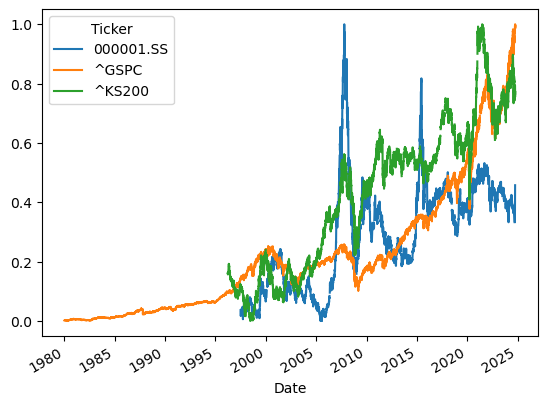

In [75]:
assets_scaled.plot()